In [126]:

import pandas as pd
from pathlib import Path
import pyarrow.parquet as pq
from dataclasses import dataclass
import hvplot.pandas 
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from matplotlib_venn import venn3, venn2
from upsetplot import UpSet


# hv.renderer('bokeh').theme = 'dark_minimal'

In [127]:
# dataset_root = Path(r"C:\Users\Raffael\Documents\Datasets\alpiq_2023") # Raw string works without escaping \
dataset_root = Path(r"C:/Users/jadbh\Documents/Swisse/EPFL/courses/Fall 2024/Machine Learning for Predictive Maintenance/project/Dataset")
dataset_root = Path(r"C:\Users\jadbh\Documents\Swisse\EPFL\courses\Fall 2024\Machine Learning for Predictive Maintenance\project\team repo\Machine-Learning-for-Predictive-Maintenance-project\Dataset")


@dataclass
class Case():
    info: pd.DataFrame
    measurements: pd.DataFrame


class RawDataset():

    def __init__(self, root, unit = "VG4", load_training=False, load_synthetic=False) -> None:
        
        
        read_pq_file = lambda f: pq.read_table(root / f).to_pandas()
        
        
        cases = {
            "test": [f"{unit}_generator_data_testing_real_measurements.parquet", root / f"{unit}_generator_data_testing_real_info.csv" ], 
        }
        
        if load_training:
            cases = {
                **cases,
                "train": [f"{unit}_generator_data_training_measurements.parquet", root / f"{unit}_generator_data_training_info.csv" ], 
            }
        
        if load_synthetic:
            cases = {
                **cases,
                "test_s01": [f"{unit}_generator_data_testing_synthetic_01_measurements.parquet", root / f"{unit}_generator_data_testing_synthetic_01_info.csv"], 
                "test_s02": [f"{unit}_generator_data_testing_synthetic_02_measurements.parquet", root / f"{unit}_generator_data_testing_synthetic_02_info.csv"]
            }
        
        
        self.data_dict = dict()
        
        for id_c, c in cases.items():
            # if you need to verify the parquet header:
            # pq_rows = RawDataset.read_parquet_schema_df(root / c[0])
            info = pd.read_csv(c[1])
            measurements = read_pq_file(c[0])
            self.data_dict[id_c] = Case(info, measurements)
            
        
        
    @staticmethod
    def read_parquet_schema_df(uri: str) -> pd.DataFrame:
        """Return a Pandas dataframe corresponding to the schema of a local URI of a parquet file.

        The returned dataframe has the columns: column, pa_dtype
        """
        # Ref: https://stackoverflow.com/a/64288036/
        schema = pq.read_schema(uri, memory_map=True)
        schema = pd.DataFrame(({"column": name, "pa_dtype": str(pa_dtype)} for name, pa_dtype in zip(schema.names, schema.types)))
        schema = schema.reindex(columns=["column", "pa_dtype"], fill_value=pd.NA)  # Ensures columns in case the parquet file has an empty dataframe.
        return schema
    

rds_u4 = RawDataset(dataset_root, "VG4", load_synthetic=False, load_training=True)
rds_u5 = RawDataset(dataset_root, "VG5", load_synthetic=True, load_training=True)
rds_u6 = RawDataset(dataset_root, "VG6", load_synthetic=True)

In [128]:
vg_train_meas = rds_u5.data_dict["train"].measurements
vg_train_info = rds_u5.data_dict["train"].info
# vg_test_meas = rds_u5.data_dict["test"].measurements
# vg_test_info = rds_u5.data_dict["test"].info

vg_test_meas = rds_u5.data_dict["test_s01"].measurements    # synthetic test

In [129]:
# fixing the counting of equilibrium pump
vg_train_meas['equilibrium_pump_mode'] =  (vg_train_meas['equilibrium_pump_mode'] == True) & (vg_train_meas['dyn_only_on'] == False) 
vg_test_meas['equilibrium_pump_mode'] =  (vg_test_meas['equilibrium_pump_mode'] == True) & (vg_test_meas['dyn_only_on'] == False) 

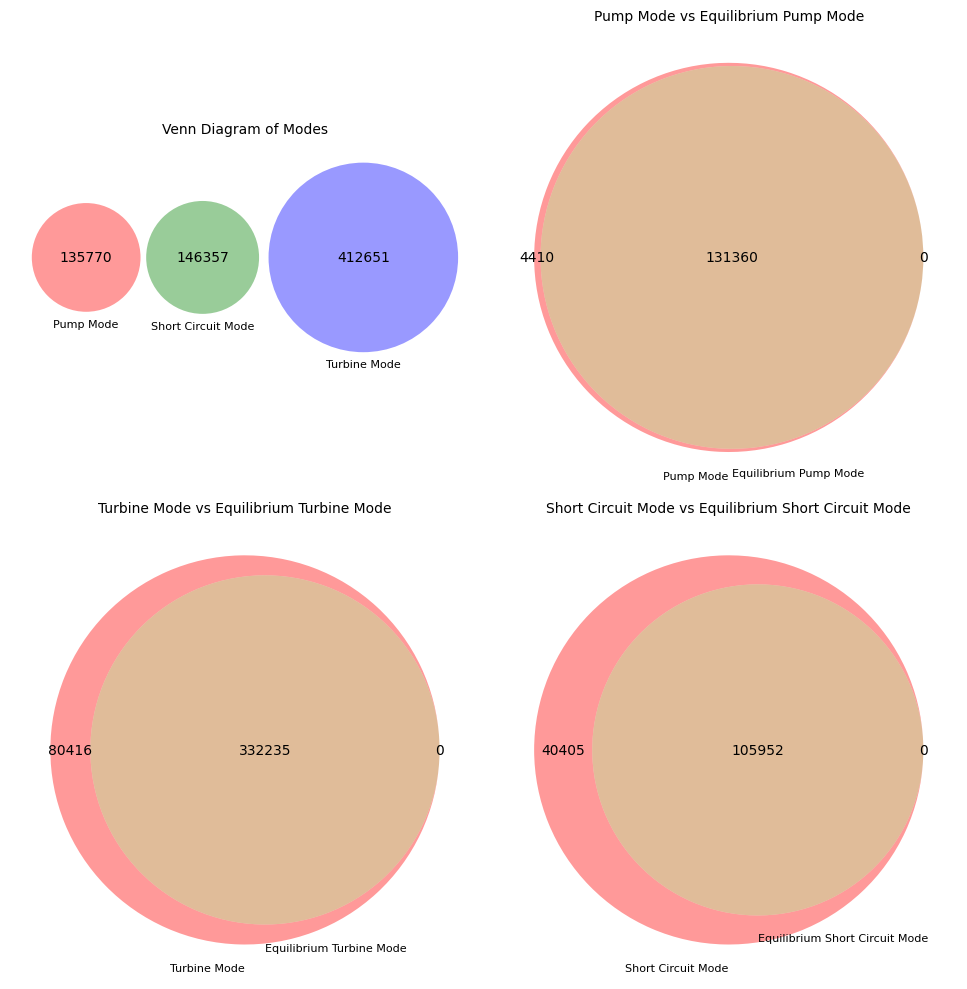

In [130]:
set_pump_mode = set(vg_train_meas.index[vg_train_meas['pump_mode']])
set_short_circuit_mode = set(vg_train_meas.index[vg_train_meas['short_circuit_mode']])
set_turbine_mode = set(vg_train_meas.index[vg_train_meas['turbine_mode']])

set_equilibrium_pump_mode = set(vg_train_meas.index[vg_train_meas['equilibrium_pump_mode']])
set_equilibrium_turbine_mode = set(vg_train_meas.index[vg_train_meas['equilibrium_turbine_mode']])
set_equilibrium_short_circuit_mode = set(vg_train_meas.index[vg_train_meas['equilibrium_short_circuit_mode']])

# Create the subplots with a smaller figure size
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Define a smaller font size for labels
label_fontsize = 8

# First subplot: Original Venn Diagram
plt.sca(axes[0, 0])
venn_diagram = venn3(
    subsets=(set_pump_mode, set_short_circuit_mode, set_turbine_mode),
    set_labels=("Pump Mode", "Short Circuit Mode", "Turbine Mode")
)
for text in venn_diagram.set_labels:
    if text:  # Avoid None
        text.set_fontsize(label_fontsize)
plt.title("Venn Diagram of Modes", fontsize=10)

# Second subplot: Pump Mode vs Equilibrium Pump Mode
plt.sca(axes[0, 1])
venn_diagram = venn2(
    subsets=(set_pump_mode, set_equilibrium_pump_mode),
    set_labels=("Pump Mode", "Equilibrium Pump Mode")
)
for text in venn_diagram.set_labels:
    if text:  # Avoid None
        text.set_fontsize(label_fontsize)
plt.title("Pump Mode vs Equilibrium Pump Mode", fontsize=10)

# Third subplot: Turbine Mode vs Equilibrium Turbine Mode
plt.sca(axes[1, 0])
venn_diagram = venn2(
    subsets=(set_turbine_mode, set_equilibrium_turbine_mode),
    set_labels=("Turbine Mode", "Equilibrium Turbine Mode")
)
for text in venn_diagram.set_labels:
    if text:  # Avoid None
        text.set_fontsize(label_fontsize)
plt.title("Turbine Mode vs Equilibrium Turbine Mode", fontsize=10)

# Fourth subplot: Short Circuit Mode vs Equilibrium Short Circuit Mode
plt.sca(axes[1, 1])
venn_diagram = venn2(
    subsets=(set_short_circuit_mode, set_equilibrium_short_circuit_mode),
    set_labels=("Short Circuit Mode", "Equilibrium Short Circuit Mode")
)
for text in venn_diagram.set_labels:
    if text:  # Avoid None
        text.set_fontsize(label_fontsize)
plt.title("Short Circuit Mode vs Equilibrium Short Circuit Mode", fontsize=10)

# Adjust layout and reduce padding
plt.tight_layout()
plt.show()


c:\Users\jadbh\Documents\Swisse\EPFL\courses\Fall 2024\Machine Learning for Predictive Maintenance\MLPMenv\Lib\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
c:\Users\jadbh\Documents\Swisse\EPFL\courses\Fall 2024\Machine Learning for Predictive Maintenance\MLPMenv\Lib\site-packages\upsetplot\plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The beha

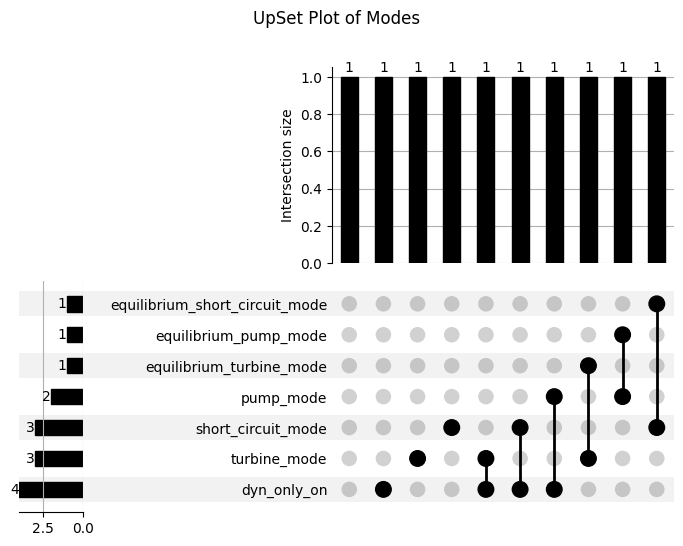

In [131]:

# Prepare data for the UpSet plot
data = pd.DataFrame({
    'pump_mode': vg_train_meas['pump_mode'],
    'short_circuit_mode': vg_train_meas['short_circuit_mode'],
    'turbine_mode': vg_train_meas['turbine_mode'],
    'equilibrium_turbine_mode': vg_train_meas['equilibrium_turbine_mode'],
    'equilibrium_pump_mode': vg_train_meas['equilibrium_pump_mode'],
    'equilibrium_short_circuit_mode': vg_train_meas['equilibrium_short_circuit_mode'],
    'dyn_only_on': vg_train_meas['dyn_only_on'],
})

# Convert to boolean intersections
data = data.astype(bool)
upset_data = data.groupby(list(data.columns)).size()

# Plot UpSet plot
upset = UpSet(upset_data, subset_size='count', show_counts=True)
upset.plot()
plt.suptitle("UpSet Plot of Modes")
plt.show()


In [132]:
print("only dyn_only_on: ", vg_train_meas[(vg_train_meas["dyn_only_on"] == True) & (vg_train_meas["equilibrium_pump_mode"] == False)].shape[0])
print("only pump equilibrium: ", vg_train_meas[(vg_train_meas["dyn_only_on"] == False) & (vg_train_meas["equilibrium_pump_mode"] == True)].shape[0])
print("both: ", vg_train_meas[(vg_train_meas["dyn_only_on"] == True) & (vg_train_meas["equilibrium_pump_mode"] == True)].shape[0])

only dyn_only_on:  132485
only pump equilibrium:  131360
both:  0


In [133]:
vg_test_meas.reset_index(inplace=True)
vg_test_filt = vg_test_meas [ (vg_test_meas['equilibrium_turbine_mode'] == True) |
                    (vg_test_meas['equilibrium_pump_mode'] == True) |
                    (vg_test_meas['equilibrium_short_circuit_mode'] == True) ]

In [134]:
vg_train_meas.reset_index(inplace=True)
vg_train_filt = vg_train_meas [ (vg_train_meas['equilibrium_turbine_mode'] == True) | 
                                 (vg_train_meas['equilibrium_pump_mode'] == True) | 
                                 (vg_train_meas['equilibrium_short_circuit_mode'] == True) ]

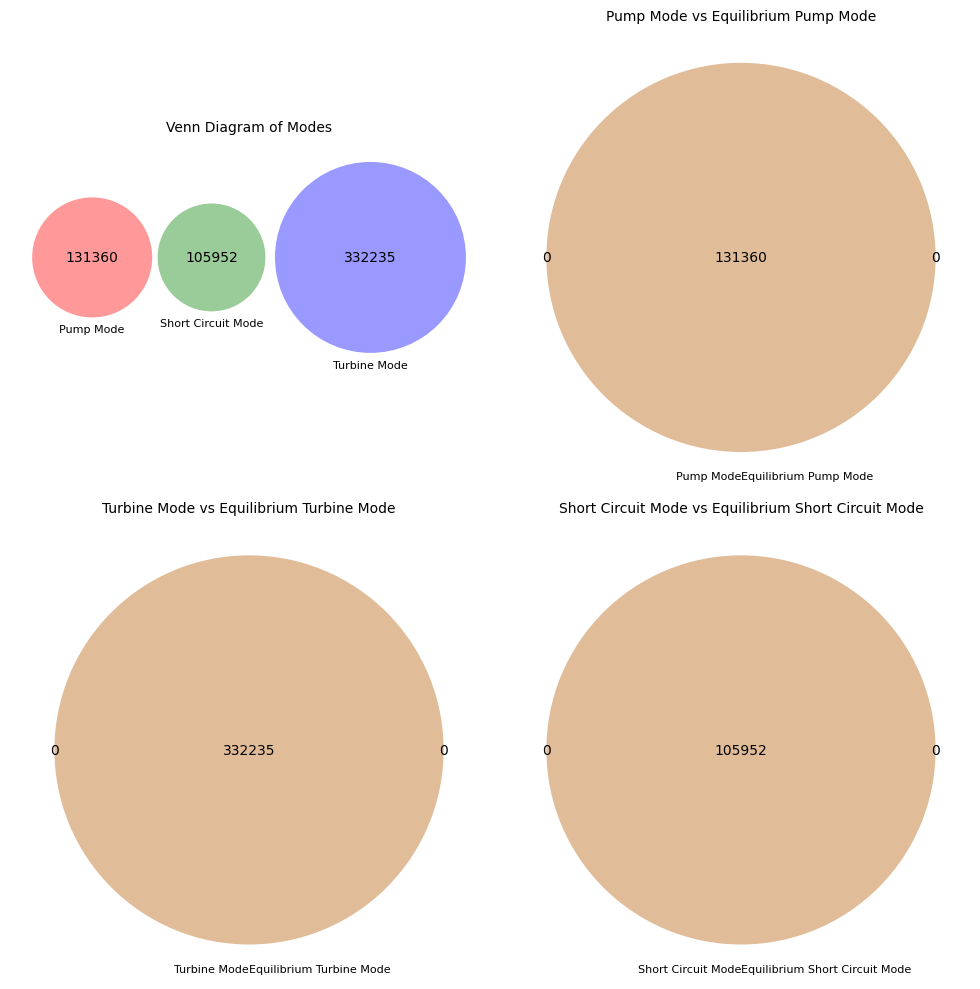

In [135]:
set_pump_mode = set(vg_train_filt.index[vg_train_filt['pump_mode']])
set_short_circuit_mode = set(vg_train_filt.index[vg_train_filt['short_circuit_mode']])
set_turbine_mode = set(vg_train_filt.index[vg_train_filt['turbine_mode']])

set_equilibrium_pump_mode = set(vg_train_filt.index[vg_train_filt['equilibrium_pump_mode']])
set_equilibrium_turbine_mode = set(vg_train_filt.index[vg_train_filt['equilibrium_turbine_mode']])
set_equilibrium_short_circuit_mode = set(vg_train_filt.index[vg_train_filt['equilibrium_short_circuit_mode']])

# Create the subplots with a smaller figure size
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Define a smaller font size for labels
label_fontsize = 8

# First subplot: Original Venn Diagram
plt.sca(axes[0, 0])
venn_diagram = venn3(
    subsets=(set_pump_mode, set_short_circuit_mode, set_turbine_mode),
    set_labels=("Pump Mode", "Short Circuit Mode", "Turbine Mode")
)
for text in venn_diagram.set_labels:
    if text:  # Avoid None
        text.set_fontsize(label_fontsize)
plt.title("Venn Diagram of Modes", fontsize=10)

# Second subplot: Pump Mode vs Equilibrium Pump Mode
plt.sca(axes[0, 1])
venn_diagram = venn2(
    subsets=(set_pump_mode, set_equilibrium_pump_mode),
    set_labels=("Pump Mode", "Equilibrium Pump Mode")
)
for text in venn_diagram.set_labels:
    if text:  # Avoid None
        text.set_fontsize(label_fontsize)
plt.title("Pump Mode vs Equilibrium Pump Mode", fontsize=10)

# Third subplot: Turbine Mode vs Equilibrium Turbine Mode
plt.sca(axes[1, 0])
venn_diagram = venn2(
    subsets=(set_turbine_mode, set_equilibrium_turbine_mode),
    set_labels=("Turbine Mode", "Equilibrium Turbine Mode")
)
for text in venn_diagram.set_labels:
    if text:  # Avoid None
        text.set_fontsize(label_fontsize)
plt.title("Turbine Mode vs Equilibrium Turbine Mode", fontsize=10)

# Fourth subplot: Short Circuit Mode vs Equilibrium Short Circuit Mode
plt.sca(axes[1, 1])
venn_diagram = venn2(
    subsets=(set_short_circuit_mode, set_equilibrium_short_circuit_mode),
    set_labels=("Short Circuit Mode", "Equilibrium Short Circuit Mode")
)
for text in venn_diagram.set_labels:
    if text:  # Avoid None
        text.set_fontsize(label_fontsize)
plt.title("Short Circuit Mode vs Equilibrium Short Circuit Mode", fontsize=10)

# Adjust layout and reduce padding
plt.tight_layout()
plt.show()


In [136]:
# separating the three operation modes for train

df_pump = vg_train_filt[vg_train_filt["equilibrium_pump_mode"] == True]
df_turbine = vg_train_filt[vg_train_filt["equilibrium_turbine_mode"] == True]
df_short_circuit = vg_train_filt[vg_train_filt["equilibrium_short_circuit_mode"] == True]

print("TRAIN DATASET")
print("size of pump dataset: ", df_pump.shape[0])
print("size of turbine dataset: ", df_turbine.shape[0])
print("size of short circuit dataset: ", df_short_circuit.shape[0])

TRAIN DATASET
size of pump dataset:  131360
size of turbine dataset:  332235
size of short circuit dataset:  105952


In [137]:
# same for testing

df_test_pump = vg_test_filt[vg_test_filt["equilibrium_pump_mode"] == True]
df_test_turbine = vg_test_filt[vg_test_filt["equilibrium_turbine_mode"] == True]
df_test_short_circuit = vg_test_filt[vg_test_filt["equilibrium_short_circuit_mode"] == True]

print("TEST DATASET")
print("size of pump dataset: ", df_pump.shape[0])
print("size of turbine dataset: ", df_turbine.shape[0])
print("size of short circuit dataset: ", df_short_circuit.shape[0])

TEST DATASET
size of pump dataset:  131360
size of turbine dataset:  332235
size of short circuit dataset:  105952


In [138]:
# summary of VG5 useful variables

vg_train_info
vg_train_filt      # equilibirum
vg_train_meas

df_pump
df_turbine
df_short_circuit

vg_test_meas
vg_test_filt         # equilibrium

df_test_pump
df_test_turbine
df_test_short_circuit

print()

In [139]:
# choosing which mode

mode = "pump" 

mode_mapping = {
    "pump": (df_pump, df_test_pump),
    "turbine": (df_turbine, df_test_turbine),
    "short_circuit": (df_short_circuit, df_test_short_circuit)
}

if mode in mode_mapping:
    df, df_test = mode_mapping[mode]

    if mode == "pump":
        print("train pump OG: ", df.head(3))
        # Drop columns 6 to 10
        df.drop(df.columns[6:11], axis=1, inplace=True)
        df_test.drop(df_test.columns[6:11], axis=1, inplace=True)
        print("Dropped columns 6 to 10 (injectors) for mode 'pump'.")

    elif mode == "turbine":
        # Average columns 6 to 10 into a new column
        df['avg_injector_opening'] = df.iloc[:, 6:11].mean(axis=1)
        df_test['avg_injector_opening'] = df_test.iloc[:, 5:10].mean(axis=1)
        
        # Drop original columns
        df.drop(df.columns[6:11], axis=1, inplace=True)
        df_test.drop(df_test.columns[6:11], axis=1, inplace=True)
        print("Averaged columns 6 to 10 into 'avg_injector_opening' for mode 'turbine'.")

    print(f"Mode selected: {mode}")
    print(df.columns)
    display(df.head(3))

else:
    print("Invalid mode selected. Please choose from: 'pump', 'turbine', or 'short_circuit'.")

print(df.columns)
df.head(3)

train pump OG:                         index  tot_activepower   ext_tmp  plant_tmp    charge  \
19 2020-01-02 00:09:30+01:00      -118.473546  6.168317  16.534002 -2.028008   
20 2020-01-02 00:10:00+01:00      -118.519180  6.120397  16.551231 -1.582541   
21 2020-01-02 00:10:30+01:00      -118.568768  6.072477  16.568460 -1.492840   

    coupler_position  injector_01_opening  injector_02_opening  \
19        185.042366                  0.0                  0.0   
20        185.042057                  0.0                  0.0   
21        185.041749                  0.0                  0.0   

    injector_03_opening  injector_04_opening  ...  machine_on  machine_off  \
19                  0.0                  0.0  ...        True        False   
20                  0.0                  0.0  ...        True        False   
21                  0.0                  0.0  ...        True        False   

    turbine_mode   all  equilibrium_turbine_mode  dyn_only_on  pump_mode  \
19       

C:\Users\jadbh\AppData\Local\Temp\ipykernel_26596\289086717.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df.columns[6:11], axis=1, inplace=True)
C:\Users\jadbh\AppData\Local\Temp\ipykernel_26596\289086717.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(df_test.columns[6:11], axis=1, inplace=True)


,index,tot_activepower,ext_tmp,plant_tmp,charge,coupler_position,pump_calculated_flow,pump_pressure_diff,pump_rotspeed,tot_current,...,machine_on,machine_off,turbine_mode,all,equilibrium_turbine_mode,dyn_only_on,pump_mode,short_circuit_mode,equilibrium_pump_mode,equilibrium_short_circuit_mode
19,2020-01-02 00:09:30+01:00,-118.473546,6.168317,16.534002,-2.028008,185.042366,12.963417,337.437515,498.786652,4383.001616,...,True,False,False,True,False,False,True,False,True,False
20,2020-01-02 00:10:00+01:00,-118.519180,6.120397,16.551231,-1.582541,185.042057,12.951425,337.666687,498.720032,4386.539517,...,True,False,False,True,False,False,True,False,True,False
21,2020-01-02 00:10:30+01:00,-118.568768,6.072477,16.568460,-1.492840,185.041749,12.939433,337.635729,499.386698,4390.077418,...,True,False,False,True,False,False,True,False,True,False


Index(['index', 'tot_activepower', 'ext_tmp', 'plant_tmp', 'charge',
       'coupler_position', 'pump_calculated_flow', 'pump_pressure_diff',
       'pump_rotspeed', 'tot_current', 'tot_effectivepower',
       'tot_reactivepower', 'turbine_pressure', 'turbine_rotspeed',
       'water_primary_pump_01_opening', 'water_primary_pump_02_opening',
       'air_circ_cold_01_tmp', 'air_circ_cold_02_tmp', 'air_circ_cold_03_tmp',
       'air_circ_cold_04_tmp', 'air_circ_cold_05_tmp', 'air_circ_cold_06_tmp',
       'air_circ_hot_01_tmp', 'air_circ_hot_02_tmp', 'air_circ_hot_03_tmp',
       'air_circ_hot_04_tmp', 'air_circ_hot_05_tmp', 'air_circ_hot_06_tmp',
       'elec_freq', 'exc_current', 'exc_voltage', 'mid_voltage',
       'neutral_current', 'ph01_current', 'ph01_voltage', 'ph12_voltage',
       'ph02_current', 'ph02_voltage', 'ph23_voltage', 'ph03_current',
       'ph03_voltage', 'ph31_voltage', 'stat_coil_ph01_01_tmp',
       'stat_coil_ph01_02_tmp', 'stat_coil_ph01_03_tmp',
       'stat_co

,index,tot_activepower,ext_tmp,plant_tmp,charge,coupler_position,pump_calculated_flow,pump_pressure_diff,pump_rotspeed,tot_current,...,machine_on,machine_off,turbine_mode,all,equilibrium_turbine_mode,dyn_only_on,pump_mode,short_circuit_mode,equilibrium_pump_mode,equilibrium_short_circuit_mode
19,2020-01-02 00:09:30+01:00,-118.473546,6.168317,16.534002,-2.028008,185.042366,12.963417,337.437515,498.786652,4383.001616,...,True,False,False,True,False,False,True,False,True,False
20,2020-01-02 00:10:00+01:00,-118.519180,6.120397,16.551231,-1.582541,185.042057,12.951425,337.666687,498.720032,4386.539517,...,True,False,False,True,False,False,True,False,True,False
21,2020-01-02 00:10:30+01:00,-118.568768,6.072477,16.568460,-1.492840,185.041749,12.939433,337.635729,499.386698,4390.077418,...,True,False,False,True,False,False,True,False,True,False


In [140]:
print("OG columns: ", df.columns.to_list())
print("OG columns length: ", len(df.columns.to_list()))
df.drop(columns=df.loc[:, 'machine_on':'equilibrium_short_circuit_mode'].columns, inplace=True)
df.drop(['index'], axis = 1, inplace=True)
print("final columns:       ", df.columns.to_list())
print("final columns lengthL", len(df.columns.to_list()))
df.sample(3)

OG columns:  ['index', 'tot_activepower', 'ext_tmp', 'plant_tmp', 'charge', 'coupler_position', 'pump_calculated_flow', 'pump_pressure_diff', 'pump_rotspeed', 'tot_current', 'tot_effectivepower', 'tot_reactivepower', 'turbine_pressure', 'turbine_rotspeed', 'water_primary_pump_01_opening', 'water_primary_pump_02_opening', 'air_circ_cold_01_tmp', 'air_circ_cold_02_tmp', 'air_circ_cold_03_tmp', 'air_circ_cold_04_tmp', 'air_circ_cold_05_tmp', 'air_circ_cold_06_tmp', 'air_circ_hot_01_tmp', 'air_circ_hot_02_tmp', 'air_circ_hot_03_tmp', 'air_circ_hot_04_tmp', 'air_circ_hot_05_tmp', 'air_circ_hot_06_tmp', 'elec_freq', 'exc_current', 'exc_voltage', 'mid_voltage', 'neutral_current', 'ph01_current', 'ph01_voltage', 'ph12_voltage', 'ph02_current', 'ph02_voltage', 'ph23_voltage', 'ph03_current', 'ph03_voltage', 'ph31_voltage', 'stat_coil_ph01_01_tmp', 'stat_coil_ph01_02_tmp', 'stat_coil_ph01_03_tmp', 'stat_coil_ph01_04_tmp', 'stat_coil_ph01_05_tmp', 'stat_coil_ph01_06_tmp', 'stat_coil_ph02_01_tmp',

C:\Users\jadbh\AppData\Local\Temp\ipykernel_26596\2553936283.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=df.loc[:, 'machine_on':'equilibrium_short_circuit_mode'].columns, inplace=True)
C:\Users\jadbh\AppData\Local\Temp\ipykernel_26596\2553936283.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['index'], axis = 1, inplace=True)


,tot_activepower,ext_tmp,plant_tmp,charge,coupler_position,pump_calculated_flow,pump_pressure_diff,pump_rotspeed,tot_current,tot_effectivepower,...,water_circ_hot_02_tmp,water_circ_hot_03_tmp,water_circ_hot_04_tmp,water_circ_hot_05_tmp,water_circ_hot_06_tmp,water_circ_hot_tmp,air_gap_negative_x_position,air_gap_positive_x_position,air_gap_negative_y_position,air_gap_positive_y_position
366459,-120.488169,10.848718,15.448233,-1.456009,185.037003,13.612689,370.838908,499.093384,4520.719776,120.658508,...,22.600000,22.100000,22.200000,22.033333,22.000000,21.700001,37.929499,35.085353,36.346555,34.573588
604821,-119.451851,20.025621,18.266066,-1.473340,185.034625,13.002411,341.450012,498.986694,4709.371680,123.107723,...,29.719967,29.500000,29.700001,29.680001,29.665910,29.709834,36.980583,34.756500,36.240383,34.812720
789036,-119.219739,16.398671,17.852526,-1.230667,185.036080,12.956579,335.150024,499.040039,4484.446426,119.668894,...,29.500000,29.415151,29.700001,29.400000,29.700001,29.615942,36.756648,35.198288,38.106917,37.468876


In [141]:
print("OG test columns: ", df_test.columns.to_list())
print("OG test columns length: ", len(df_test.columns.to_list()))
df_test.drop(columns=df_test.loc[:, 'machine_on':'equilibrium_short_circuit_mode'].columns, inplace=True)
df_test.drop(['index'], axis = 1, inplace=True)
print("final test columns:       ", df_test.columns.to_list())
print("final test columns lengthL", len(df_test.columns.to_list()))
df_test.sample(3)

OG test columns:  ['index', 'tot_activepower', 'ext_tmp', 'plant_tmp', 'charge', 'coupler_position', 'pump_calculated_flow', 'pump_pressure_diff', 'pump_rotspeed', 'tot_current', 'tot_effectivepower', 'tot_reactivepower', 'turbine_pressure', 'turbine_rotspeed', 'water_primary_pump_01_opening', 'water_primary_pump_02_opening', 'air_circ_cold_01_tmp', 'air_circ_cold_02_tmp', 'air_circ_cold_03_tmp', 'air_circ_cold_04_tmp', 'air_circ_cold_05_tmp', 'air_circ_cold_06_tmp', 'air_circ_hot_01_tmp', 'air_circ_hot_02_tmp', 'air_circ_hot_03_tmp', 'air_circ_hot_04_tmp', 'air_circ_hot_05_tmp', 'air_circ_hot_06_tmp', 'elec_freq', 'exc_current', 'exc_voltage', 'mid_voltage', 'neutral_current', 'ph01_current', 'ph01_voltage', 'ph12_voltage', 'ph02_current', 'ph02_voltage', 'ph23_voltage', 'ph03_current', 'ph03_voltage', 'ph31_voltage', 'stat_coil_ph01_01_tmp', 'stat_coil_ph01_02_tmp', 'stat_coil_ph01_03_tmp', 'stat_coil_ph01_04_tmp', 'stat_coil_ph01_05_tmp', 'stat_coil_ph01_06_tmp', 'stat_coil_ph02_01_

C:\Users\jadbh\AppData\Local\Temp\ipykernel_26596\2444778811.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(columns=df_test.loc[:, 'machine_on':'equilibrium_short_circuit_mode'].columns, inplace=True)
C:\Users\jadbh\AppData\Local\Temp\ipykernel_26596\2444778811.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(['index'], axis = 1, inplace=True)


,tot_activepower,ext_tmp,plant_tmp,charge,coupler_position,pump_calculated_flow,pump_pressure_diff,pump_rotspeed,tot_current,tot_effectivepower,...,water_circ_hot_02_tmp,water_circ_hot_03_tmp,water_circ_hot_04_tmp,water_circ_hot_05_tmp,water_circ_hot_06_tmp,water_circ_hot_tmp,air_gap_negative_x_position,air_gap_positive_x_position,air_gap_negative_y_position,air_gap_positive_y_position
112194,-119.893820,26.366170,18.774121,-1.490672,185.112888,12.957791,349.400024,499.390468,4722.483772,123.550047,...,32.038411,31.793651,32.020534,32.069519,31.890909,32.118749,36.358750,33.577000,35.363743,36.028125
90505,-117.619197,22.763365,18.479433,-1.475343,185.080968,12.648050,322.855570,498.998549,4447.279948,118.002640,...,30.621952,30.567742,30.805765,30.705001,30.877777,30.740000,36.938713,35.452893,36.160830,33.633690
16203,-119.522423,27.643057,18.253427,-1.612010,185.056143,12.921605,336.183350,499.200073,4690.000000,123.319073,...,29.600000,29.475000,29.569176,29.566667,29.560000,28.799999,37.384520,35.841878,36.444899,34.063443


In [142]:
class SlidingWindowDataset(Dataset):
    def __init__(self, dataframe, feature_columns, window_size, max_gap=10, stride = 2):
        """
        Args:
            dataframe (pd.DataFrame): The dataframe containing sensor data.
            feature_columns (list): List of column names for features.
            window_size (int): The number of timesteps in each sliding window.
            step_size (int): The step size to slide the window.
            max_gap (int): Maximum allowed gap between consecutive indices for grouping.
        """
        self.features = dataframe[feature_columns].values
        self.indices = dataframe.index.values
        self.window_size = window_size
        self.max_gap = max_gap
        self.stride = stride

        # Identify groups based on index gaps
        self.groups = self._identify_groups()
        # print(self.groups[0:50])
        # print(len(self.groups[500]))
        self.valid_windows = self._generate_valid_windows()

    def _identify_groups(self):
        """
        Identify groups of rows based on the max_gap condition.
        """
        groups = []
        current_group = [0]  # Start with the first row
        for i in range(1, len(self.indices)):
            if self.indices[i] - self.indices[i - 1] > self.max_gap:
                groups.append(current_group)
                current_group = [i]
            else:
                current_group.append(i)
        groups.append(current_group)  # Add the last group
        return groups

    def _generate_valid_windows(self):
        """
        Generate valid sliding windows based on groups.
        """
        valid_windows = []
        for group in self.groups:
            
            for start in range(0, len(group) - self.window_size + 1, self.stride):
                valid_windows.append(group[start : start + self.window_size])

            if (len(group) - self.window_size)%self.stride != 0 and len(group)> self.window_size:
                # print(len(group[len(group) - self.window_size : len(group)]))
                valid_windows.append(group[len(group) - self.window_size : len(group)])

        # print(valid_windows[-1])
        return valid_windows

    def __len__(self):
        return len(self.valid_windows)

    def __getitem__(self, idx):
        """
        Retrieve a sliding window by index.
        """
        window_indices = self.valid_windows[idx]
        x = torch.tensor(self.features[window_indices], dtype=torch.float32)
        return x

feature_columns = df.columns
# feature_columns = ["charge"]
# feature_columns = df.columns.to_string()
window_size = 100
stride = 20
max_gap = 5
batch_size = 32

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, shuffle = False)

train_df_mean = train_df.mean()
train_df_std = train_df.std()

# standardizing the features
print("TEST DF")
df_test = (df_test - train_df_mean) / train_df_std
print("Means of each column:")
print(df_test.mean().to_list())
print("\nStandard deviations of each column:")
print(df_test.std().to_list())

print("VAL DF")
val_df = (val_df - train_df_mean) / train_df_std
print("Means of each column:")
print(val_df.mean().to_list())
print("\nStandard deviations of each column:")
print(val_df.std().to_list())

print("TRAIN DF")
train_df = (train_df - train_df_mean) / train_df_std
print("Means of each column:")
print(train_df.mean().to_list())
print("\nStandard deviations of each column:")
print(train_df.std().to_list())

print("Total df shape:", df.shape)
print("Training set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)
print("Testing set shape:", df_test.shape)


# Create Dataset and DataLoader
train_dataset = SlidingWindowDataset(train_df, feature_columns, window_size, max_gap, stride = stride)
val_dataset = SlidingWindowDataset(val_df, feature_columns, window_size, max_gap, stride = stride)
test_dataset = SlidingWindowDataset(df_test, feature_columns, window_size, max_gap, stride = stride)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print("train dataloader length: ", len(train_dataloader))
print("train dataloader dataset length: ", len(train_dataloader.dataset))

print("val dataloader length: ", len(val_dataloader))
print("val dataloader dataset length: ", len(val_dataloader.dataset))

print("test dataloader length: ", len(test_dataloader.dataset))
print("test dataloader dataset length: ", len(test_dataloader.dataset))

# maxes = []
# # Example: Iterating through the dataloader
# for i, batch in enumerate(dataloader):
#     sliding_windows = batch
#     diff = sliding_windows[0,1:10,1] - sliding_windows[0,0:9,1]
#     maxes.append(diff.max().item())
#     # print(maxes)  # Replace with your training loop logi
#     # if i>100:
#     #     break
# # plt.hist(maxes)
# pd_maxes = pd.DataFrame(maxes)
# pd_maxes.value_counts()

TEST DF
Means of each column:
[0.5101579122200977, 1.5808045134465794, 0.42050382468002107, -0.03335786152590269, 0.018238274606122158, -0.589193682808335, -0.5810629292891031, 0.12240883809060155, 0.3325740767437151, -0.13231541206781133, -0.665792869846429, 0.029493574162948174, 0.4818634469018255, 0.522775414941353, 0.6271405977197196, 1.1191820274133921, 1.1120272490609386, 1.1189676793408647, 1.1130614501789728, 1.1148805967454616, 1.1154661685436444, 0.7467842279623863, 0.7569366617700464, 0.7597866979519654, 0.7599452576128038, 0.7526463474248081, 0.7502273649001661, 0.04924102549545845, -0.7251267885468085, -0.46362768938152277, -0.6261169335432567, 1.0664572648674542, 0.31687767398576067, -0.6362005701783139, -0.6613411962079339, 0.29463977411342124, -0.6711220503295386, -0.6823953667949991, 0.38430350200196534, -0.6580732684130371, -0.6489756802576996, 0.6860436193869147, 0.6782046622962202, 0.6645104089560019, 0.6691039976102595, 0.16427852353254366, 0.6325693675787115, 0.65

In [143]:
class DenseAutoencoder(nn.Module):

    def __init__(self, input_dim, dropout_rate = 0.5):
        super(DenseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 12),     # 64
            nn.LayerNorm(12)
            )
                          
        self.decoder = nn.Sequential(
            nn.Linear(12,128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, input_dim)
            # nn.Sigmoid()
            )

    def forward(self, x):
        feature = self.encoder(x)
        reconstruction = self.decoder(feature)
        return reconstruction, feature

In [144]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0
    total_samples = 0

    for _ , x in enumerate(tqdm(dataloader)):
        batch_size = x.shape[0]
        total_samples += batch_size
        
        x = x.flatten(start_dim=1)
        optimizer.zero_grad()
        x_pred, _ = model(x)
        
        loss = loss_fn(x_pred, x)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch_size

    average_loss = total_loss / total_samples
    print(f"Train Loss: {average_loss:.3f}")
    return average_loss

def test_loop(dataloader, model, loss_fn):
    model.eval()
    total_loss = 0
    total_samples = 0
    full_reconstruction = torch.Tensor([])

    with torch.no_grad():
        for _, x in enumerate(tqdm(dataloader)):
            batch_size, seq_len, feature_dim = x.shape
            total_samples += batch_size

            x = x.flatten(start_dim=1)

            x_pred, _ = model(x)
            reconstruction = x_pred.view(batch_size, seq_len, feature_dim)
            full_reconstruction = torch.cat((full_reconstruction, reconstruction), dim=0)

            loss = loss_fn(x_pred, x)
            total_loss += loss.item() * batch_size 

    average_loss = total_loss / total_samples
    print(f"Test loop Loss: {average_loss:.3f}")
    return average_loss, full_reconstruction

model = DenseAutoencoder(window_size * len(feature_columns))
epochs = 2
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001, weight_decay=1e-5)
loss_fn = nn.MSELoss()


In [145]:
train_loss_evol = []
val_loss_evol = []
test_loss_evol = []
test_predictions = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    
    # Training loop
    train_loss_evol.append(train_loop(train_dataloader, model, loss_fn, optimizer))
    
    # Validation loop
    val_loss, _ = test_loop(val_dataloader, model, loss_fn)
    val_loss_evol.append(val_loss)
    
    # Test loop
    test_loss, _ = test_loop(test_dataloader, model, loss_fn)
    test_loss_evol.append(test_loss)


Epoch 1
-------------------------------


100%|██████████| 144/144 [00:06<00:00, 22.51it/s]


Train Loss: 0.427


100%|██████████| 37/37 [00:00<00:00, 98.33it/s] 


Test loop Loss: 0.326


100%|██████████| 27/27 [00:00<00:00, 125.97it/s]


Test loop Loss: 0.285
Epoch 2
-------------------------------


100%|██████████| 144/144 [00:05<00:00, 24.49it/s]


Train Loss: 0.278


100%|██████████| 37/37 [00:00<00:00, 129.80it/s]


Test loop Loss: 0.301


100%|██████████| 27/27 [00:00<00:00, 135.27it/s]

Test loop Loss: 0.230


Text(0.5, 1.0, 'Loss evolution')

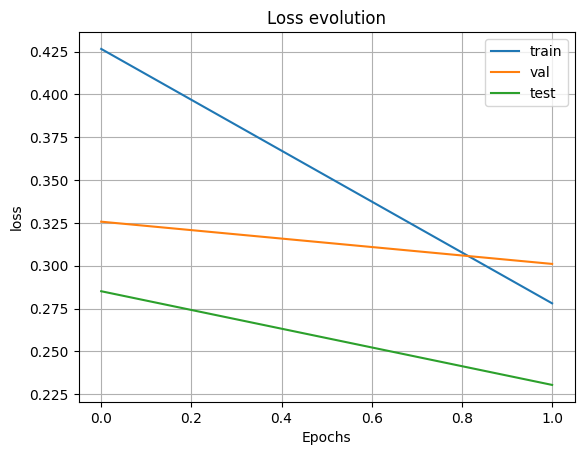

In [146]:
plt.plot((train_loss_evol), label = 'train')
plt.plot((val_loss_evol), label = 'val')
plt.plot((test_loss_evol), label = 'test')
plt.legend()
plt.grid()
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.title('Loss evolution')

In [147]:
# Create Dataset and DataLoader
ordered_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
ordered_test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

_ , reconstruction = test_loop(ordered_train_dataloader, model, loss_fn)

100%|██████████| 144/144 [00:01<00:00, 76.18it/s]

Test loop Loss: 0.197


In [148]:
from sklearn.preprocessing import StandardScaler

# Copy and trim the DataFrame
vg_train_filt_copy = vg_train_filt.copy()
vg_train_filt_copy.drop(vg_train_filt_copy.columns[6:11], axis=1, inplace=True)
vg_train_filt_copy.drop(vg_train_filt_copy.columns[85:], axis=1, inplace=True)
vg_train_filt_copy.rename(columns={"index": "timestamp"}, inplace=True)

# # Extract the 'index' column before dropping it
timestamps = vg_train_filt_copy['timestamp']

# # # # Drop the 'index' column for standardization
features = vg_train_filt_copy.drop(columns=['timestamp'])

# # # Standardize the features
scaler = StandardScaler()
standardized_features = scaler.fit_transform(features)

# # Recreate the DataFrame
vg_train_filt_copy = pd.DataFrame(standardized_features, columns=features.columns)

# # # Add the 'index' column back
vg_train_filt_copy['timestamp'] = timestamps

In [342]:
for i, batch in enumerate(train_dataset):

    tensor_df = pd.DataFrame(batch.numpy(), columns=vg_train_filt_copy.drop(columns = ['timestamp']).columns)    # already standardized with train_mean and train_std

    if i == 1 :
        break

In [150]:
tensor_df['ext_tmp'].sort_values()

26   -1.465725
25   -1.465149
27   -1.463572
24   -1.463403
23   -1.461656
        ...   
49   -1.424872
45   -1.424818
48   -1.424344
47   -1.423817
46   -1.423290
Name: ext_tmp, Length: 100, dtype: float32

In [402]:
vg_train_filt_copy2 = vg_train_filt.copy()
vg_train_filt_copy2.rename(columns={"index": "timestamp"}, inplace=True)
vg_train_filt_copy2.drop(vg_train_filt_copy2.columns[6:11], axis=1, inplace=True)
vg_train_filt_copy2.drop(vg_train_filt_copy2.columns[85:], axis=1, inplace=True)
timestamps = vg_train_filt_copy2['timestamp']
vg_train_filt_copy2.drop(vg_train_filt_copy2.columns[0], axis=1, inplace=True)
vg_train_filt_copy2 = ((vg_train_filt_copy2 - train_df_mean) / (train_df_std))
vg_train_filt_copy2['timestamps'] = timestamps
vg_train_filt_copy2['ext_tmp'] = vg_train_filt_copy2['ext_tmp'].round(10)
tensor_df['ext_tmp'] = tensor_df['ext_tmp']#.round(10)
vg_train_filt_copy2['tot_reactivepower'] = vg_train_filt_copy2['tot_reactivepower']#.round(6)

In [356]:
# 569547 

# Count unique values in each column
unique_counts = vg_train_filt_copy2.nunique()
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# Display the counts
print(unique_counts.sort_values())

pump_rotspeed                      8555
turbine_rotspeed                  26035
air_circ_cold_01_tmp              92895
air_circ_cold_03_tmp              95214
air_circ_cold_04_tmp              95569
air_circ_cold_02_tmp              95857
air_circ_cold_06_tmp              98572
air_circ_cold_05_tmp             101570
exc_voltage                      142496
pump_pressure_diff               154265
water_circ_cold_tmp              181419
water_circ_hot_tmp               185803
water_primary_pump_02_opening    198995
water_circ_flow                  201421
water_circ_hot_06_tmp            201463
water_primary_pump_01_opening    201914
water_circ_hot_05_tmp            215410
water_circ_hot_02_tmp            217856
water_circ_hot_01_tmp            218619
water_circ_hot_03_tmp            222173
coupler_position                 235636
pump_calculated_flow             235694
charge                           257634
water_circ_hot_04_tmp            269365
turbine_pressure                 303970


In [447]:
counter2 = 0
counter1 = 0
counter1_prev = 0
indices = []
for i in vg_train_filt_copy2.index:
    
    counter1 += (np.isclose(tensor_df['ext_tmp'], vg_train_filt_copy2['ext_tmp'][i].item(), 1e-19)).sum()

    if counter1> counter1_prev:
        indices.append(i)
    if counter1 == window_size:
        break
    counter1_prev = counter1

In [456]:
indices

tensor_df['added_timestamps'] = vg_train_filt_copy2['timestamps'][indices].values

In [457]:
tensor_df

,tot_activepower,ext_tmp,plant_tmp,charge,coupler_position,pump_calculated_flow,pump_pressure_diff,pump_rotspeed,tot_current,tot_effectivepower,tot_reactivepower,turbine_pressure,turbine_rotspeed,water_primary_pump_01_opening,water_primary_pump_02_opening,air_circ_cold_01_tmp,air_circ_cold_02_tmp,air_circ_cold_03_tmp,air_circ_cold_04_tmp,air_circ_cold_05_tmp,air_circ_cold_06_tmp,air_circ_hot_01_tmp,air_circ_hot_02_tmp,air_circ_hot_03_tmp,air_circ_hot_04_tmp,air_circ_hot_05_tmp,air_circ_hot_06_tmp,elec_freq,exc_current,exc_voltage,mid_voltage,neutral_current,ph01_current,ph01_voltage,ph12_voltage,ph02_current,ph02_voltage,ph23_voltage,ph03_current,ph03_voltage,ph31_voltage,stat_coil_ph01_01_tmp,stat_coil_ph01_02_tmp,stat_coil_ph01_03_tmp,stat_coil_ph01_04_tmp,stat_coil_ph01_05_tmp,stat_coil_ph01_06_tmp,stat_coil_ph02_01_tmp,stat_coil_ph02_02_tmp,stat_coil_ph02_03_tmp,stat_coil_ph02_04_tmp,stat_coil_ph02_05_tmp,stat_coil_ph02_06_tmp,stat_coil_ph03_01_tmp,stat_coil_ph03_02_tmp,stat_coil_ph03_03_tmp,stat_coil_ph03_04_tmp,stat_coil_ph03_05_tmp,stat_coil_ph03_06_tmp,stat_magn_01_tmp,stat_magn_02_tmp,stat_magn_03_tmp,stat_magn_04_tmp,stat_magn_05_tmp,stat_magn_06_tmp,stat_magn_07_tmp,stat_magn_08_tmp,stat_magn_09_tmp,stat_magn_10_tmp,stat_magn_11_tmp,stat_magn_12_tmp,water_circ_cold_tmp,water_circ_flow,water_circ_hot_01_tmp,water_circ_hot_02_tmp,water_circ_hot_03_tmp,water_circ_hot_04_tmp,water_circ_hot_05_tmp,water_circ_hot_06_tmp,water_circ_hot_tmp,air_gap_negative_x_position,air_gap_positive_x_position,air_gap_negative_y_position,air_gap_positive_y_position,added_timestamps
0,0.283120,-1.431665,-0.559599,-0.111268,-0.338263,-0.160776,-0.178277,0.395654,-1.096630,-0.564680,1.051997,-0.334088,-0.727588,-0.421545,-0.440487,-1.218645,-1.210447,-1.213236,-1.207108,-1.215817,-1.211343,-0.710321,-0.758522,-0.768470,-0.757328,-0.768121,-0.760174,0.650476,0.675273,0.536669,1.451620,0.332996,-1.284934,1.263354,1.252402,-1.275195,1.215631,1.241685,-1.153625,1.219784,1.263199,-0.746952,-0.761629,-0.730382,-0.753807,-0.736894,-0.771205,-0.733338,-0.739574,-0.748484,-0.729810,-0.706365,-0.694571,-0.734385,-0.730949,-0.722017,-0.722251,-0.717337,-0.756171,-0.579029,-0.636667,-0.653081,-0.580573,-0.661428,-0.657392,-0.633087,-0.584359,-0.662992,-0.614892,-0.631563,-0.661670,-1.158297,1.463879,-1.180127,-1.176722,-1.131976,-1.194897,-1.224524,-1.050817,-1.219068,0.224460,-0.365968,0.351551,-0.283384,2020-01-01 23:19:30
1,0.653584,-1.431605,-0.574915,-0.158856,-0.338263,-0.173877,-0.424307,0.228156,-1.238470,-0.799025,1.062027,-0.336848,-1.673426,-0.421545,-0.440563,-1.218645,-1.210447,-1.213236,-1.207108,-1.215817,-1.211343,-0.709416,-0.756863,-0.768470,-0.757328,-0.768121,-0.757071,0.672762,0.710886,0.514852,1.449385,0.339646,-1.301578,1.265988,1.257723,-1.275300,1.219132,1.246346,-1.170129,1.228483,1.266918,-0.746952,-0.760891,-0.729578,-0.753807,-0.734892,-0.770127,-0.733338,-0.738773,-0.747987,-0.729220,-0.704475,-0.694571,-0.733552,-0.730949,-0.722017,-0.721515,-0.715563,-0.755684,-0.576150,-0.635884,-0.649543,-0.578145,-0.661428,-0.654542,-0.632249,-0.581995,-0.659417,-0.612627,-0.630712,-0.657988,-1.199067,1.294595,-1.176778,-1.176722,-1.137719,-1.209082,-1.184369,-1.147150,-1.128793,0.039420,-1.706748,-0.600872,-0.259872,2020-01-01 23:20:00
2,0.503603,-1.431545,-0.590232,-0.309030,-0.338263,-0.186978,-0.349751,0.864571,-1.179596,-0.700101,1.075085,-0.339607,-0.813537,-0.421545,-0.440640,-1.218645,-1.210447,-1.213236,-1.207108,-1.215817,-1.210299,-0.709416,-0.755204,-0.767568,-0.756430,-0.767218,-0.753969,0.695049,0.852217,0.598863,1.447150,0.323020,-1.318221,1.275065,1.264930,-1.275405,1.230477,1.254338,-1.186634,1.240068,1.275361,-0.746114,-0.760891,-0.729578,-0.752969,-0.732933,-0.769050,-0.732513,-0.738773,-0.747490,-0.728630,-0.702658,-0.694571,-0.733552,-0.730949,-0.722017,-0.721515,-0.713829,-0.755197,-0.573272,-0.635884,-0.646005,-0.575718,-0.660567,-0.651692,-0.631412,-0.579632,-0.655843,-0.610362,-0.629860,-0.654306,-1.219452,1.30

In [396]:
(tensor_df['ext_tmp']== -1.4316647052764893).sum()
(tensor_df['ext_tmp'])[0]

np.float32(-1.4316647)

In [366]:
tensor_df_mini = tensor_df[0:1]
tensor_df_mini['ext_tmp']

0   -1.431665
Name: ext_tmp, dtype: float32

In [ ]:
# count_exact = (tensor_df['ext_tmp'] == vg_train_filt_copy2['ext_tmp'].sort_values()[60].item()).sum()

np.int64(1)

In [359]:
# Ensure join_cols includes the correct matching columns
join_cols = list(tensor_df.columns)

# Correct the merge statement
tensor_df_with_timestamp = pd.merge(
    tensor_df,
    vg_train_filt_copy2[['ext_tmp' ,'timestamps']],  # Select only relevant columns
    on=['ext_tmp'] ,  # Use the correct matching column
    how='left'
)

In [360]:
tensor_df_with_timestamp

,tot_activepower,ext_tmp,plant_tmp,charge,coupler_position,pump_calculated_flow,pump_pressure_diff,pump_rotspeed,tot_current,tot_effectivepower,tot_reactivepower,turbine_pressure,turbine_rotspeed,water_primary_pump_01_opening,water_primary_pump_02_opening,air_circ_cold_01_tmp,air_circ_cold_02_tmp,air_circ_cold_03_tmp,air_circ_cold_04_tmp,air_circ_cold_05_tmp,air_circ_cold_06_tmp,air_circ_hot_01_tmp,air_circ_hot_02_tmp,air_circ_hot_03_tmp,air_circ_hot_04_tmp,air_circ_hot_05_tmp,air_circ_hot_06_tmp,elec_freq,exc_current,exc_voltage,mid_voltage,neutral_current,ph01_current,ph01_voltage,ph12_voltage,ph02_current,ph02_voltage,ph23_voltage,ph03_current,ph03_voltage,ph31_voltage,stat_coil_ph01_01_tmp,stat_coil_ph01_02_tmp,stat_coil_ph01_03_tmp,stat_coil_ph01_04_tmp,stat_coil_ph01_05_tmp,stat_coil_ph01_06_tmp,stat_coil_ph02_01_tmp,stat_coil_ph02_02_tmp,stat_coil_ph02_03_tmp,stat_coil_ph02_04_tmp,stat_coil_ph02_05_tmp,stat_coil_ph02_06_tmp,stat_coil_ph03_01_tmp,stat_coil_ph03_02_tmp,stat_coil_ph03_03_tmp,stat_coil_ph03_04_tmp,stat_coil_ph03_05_tmp,stat_coil_ph03_06_tmp,stat_magn_01_tmp,stat_magn_02_tmp,stat_magn_03_tmp,stat_magn_04_tmp,stat_magn_05_tmp,stat_magn_06_tmp,stat_magn_07_tmp,stat_magn_08_tmp,stat_magn_09_tmp,stat_magn_10_tmp,stat_magn_11_tmp,stat_magn_12_tmp,water_circ_cold_tmp,water_circ_flow,water_circ_hot_01_tmp,water_circ_hot_02_tmp,water_circ_hot_03_tmp,water_circ_hot_04_tmp,water_circ_hot_05_tmp,water_circ_hot_06_tmp,water_circ_hot_tmp,air_gap_negative_x_position,air_gap_positive_x_position,air_gap_negative_y_position,air_gap_positive_y_position,timestamps
0,0.283120,-1.431665,-0.559599,-0.111268,-0.338263,-0.160776,-0.178277,0.395654,-1.096630,-0.564680,1.051997,-0.334088,-0.727588,-0.421545,-0.440487,-1.218645,-1.210447,-1.213236,-1.207108,-1.215817,-1.211343,-0.710321,-0.758522,-0.768470,-0.757328,-0.768121,-0.760174,0.650476,0.675273,0.536669,1.451620,0.332996,-1.284934,1.263354,1.252402,-1.275195,1.215631,1.241685,-1.153625,1.219784,1.263199,-0.746952,-0.761629,-0.730382,-0.753807,-0.736894,-0.771205,-0.733338,-0.739574,-0.748484,-0.729810,-0.706365,-0.694571,-0.734385,-0.730949,-0.722017,-0.722251,-0.717337,-0.756171,-0.579029,-0.636667,-0.653081,-0.580573,-0.661428,-0.657392,-0.633087,-0.584359,-0.662992,-0.614892,-0.631563,-0.661670,-1.158297,1.463879,-1.180127,-1.176722,-1.131976,-1.194897,-1.224524,-1.050817,-1.219068,0.224460,-0.365968,0.351551,-0.283384,NaT
1,0.653584,-1.431605,-0.574915,-0.158856,-0.338263,-0.173877,-0.424307,0.228156,-1.238470,-0.799025,1.062027,-0.336848,-1.673426,-0.421545,-0.440563,-1.218645,-1.210447,-1.213236,-1.207108,-1.215817,-1.211343,-0.709416,-0.756863,-0.768470,-0.757328,-0.768121,-0.757071,0.672762,0.710886,0.514852,1.449385,0.339646,-1.301578,1.265988,1.257723,-1.275300,1.219132,1.246346,-1.170129,1.228483,1.266918,-0.746952,-0.760891,-0.729578,-0.753807,-0.734892,-0.770127,-0.733338,-0.738773,-0.747987,-0.729220,-0.704475,-0.694571,-0.733552,-0.730949,-0.722017,-0.721515,-0.715563,-0.755684,-0.576150,-0.635884,-0.649543,-0.578145,-0.661428,-0.654542,-0.632249,-0.581995,-0.659417,-0.612627,-0.630712,-0.657988,-1.199067,1.294595,-1.176778,-1.176722,-1.137719,-1.209082,-1.184369,-1.147150,-1.128793,0.039420,-1.706748,-0.600872,-0.259872,NaT
2,0.503603,-1.431545,-0.590232,-0.309030,-0.338263,-0.186978,-0.349751,0.864571,-1.179596,-0.700101,1.075085,-0.339607,-0.813537,-0.421545,-0.440640,-1.218645,-1.210447,-1.213236,-1.207108,-1.215817,-1.210299,-0.709416,-0.755204,-0.767568,-0.756430,-0.767218,-0.753969,0.695049,0.852217,0.598863,1.447150,0.323020,-1.318221,1.275065,1.264930,-1.275405,1.230477,1.254338,-1.186634,1.240068,1.275361,-0.746114,-0.760891,-0.729578,-0.752969,-0.732933,-0.769050,-0.732513,-0.738773,-0.747490,-0.728630,-0.702658,-0.694571,-0.733552,-0.730949,-0.722017,-0.721515,-0.713829,-0.755197,-0.573272,-0.635884,-0.646005,-0.575718,-0.660567,-0.651692,-0.631412,-0.579632,-0.655843,-0.610362,-0.629860,-0.654306,-1.219452,1.306945,-1.198212,-1.116523,-1.177922,-1.

In [154]:
tensor_df_with_timestamp

,tot_activepower,ext_tmp,plant_tmp,charge,coupler_position,pump_calculated_flow,pump_pressure_diff,pump_rotspeed,tot_current,tot_effectivepower,...,water_circ_hot_03_tmp,water_circ_hot_04_tmp,water_circ_hot_05_tmp,water_circ_hot_06_tmp,water_circ_hot_tmp,air_gap_negative_x_position,air_gap_positive_x_position,air_gap_negative_y_position,air_gap_positive_y_position,timestamps
0,0.283120,-1.431665,-0.559599,-0.111268,-0.338263,-0.160776,-0.178277,0.395654,-1.096630,-0.564680,...,-1.131976,-1.194897,-1.224524,-1.050817,-1.219068,0.224460,-0.365968,0.351551,-0.283384,NaT
1,0.653584,-1.431605,-0.574915,-0.158856,-0.338263,-0.173877,-0.424307,0.228156,-1.238470,-0.799025,...,-1.137719,-1.209082,-1.184369,-1.147150,-1.128793,0.039420,-1.706748,-0.600872,-0.259872,NaT
2,0.503603,-1.431545,-0.590232,-0.309030,-0.338263,-0.186978,-0.349751,0.864571,-1.179596,-0.700101,...,-1.177922,-1.223266,-1.244602,-1.151163,-1.259190,-0.145620,-1.324949,-0.324706,-0.227123,NaT
3,0.550978,-1.431485,-0.605548,0.177908,-0.338263,-0.200079,-0.271374,0.546363,-1.201982,-0.712219,...,-1.228175,-1.212155,-1.214486,-1.131094,-1.339435,-0.330660,-0.326412,-0.048540,-0.180520,NaT
4,0.391037,-1.431426,-0.620865,0.184113,-0.338263,-0.213180,-0.475921,0.563075,-1.323361,-0.607720,...,-1.177922,-1.188041,-1.155687,-1.111025,-0.958274,-0.515701,0.749554,0.227626,-0.133916,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.853751,-1.434989,-0.579968,-0.593855,0.642070,-0.415998,-0.557166,-1.714358,-0.733091,-0.914631,...,-1.177922,-1.203782,-1.204447,-1.205196,-1.128793,-1.354147,-0.492618,0.656291,0.084215,NaT
96,0.914456,-1.435204,-0.578165,-0.227120,0.673807,-0.428011,-0.609737,0.221456,-0.699712,-0.951182,...,-1.176582,-1.192507,-1.196918,-1.133961,-1.176586,0.272329,-0.003067,0.656706,-0.590959,NaT
97,0.450089,-1.435419,-0.576362,-0.197543,0.705545,-0.440024,-0.399454,0.496152,-0.666334,-0.645500,...,-1.210586,-1.176334,-1.237073,-1.070886,-1.158885,-0.209189,0.486484,0.657120,-1.266134,NaT
98,0.644075,-1.435635,-0.574559,-0.065114,0.689333,-0.452036,-0.551112,0.308555,-0.707816,-0.764074,...,-1.184622,-1.202544,-1.204447,-1.231441,-1.209037,-0.690707,0.976035,0.657535,0.281745,NaT


In [155]:
((vg_train_filt_copy.drop(columns='timestamp') - train_df_mean) / train_df_std)['ext_tmp']

0        -2.505770
1        -2.506884
2        -2.507998
3        -2.509113
4        -2.510227
            ...   
569542   -2.402620
569543   -2.403037
569544   -2.403454
569545   -2.403871
569546   -2.404288
Name: ext_tmp, Length: 569547, dtype: float64

In [156]:
tensor_df
vg_train_meas
join_cols = list(tensor_df.columns)
one = tensor_df[0:1]
one
# # (vg_train_meas[join_cols] == one)['ext_tmp']
# (vg_train_meas[join_cols])

# matching_row = vg_train_meas[join_cols][(vg_train_meas[join_cols] == one.iloc[0]).all(axis=1)]

# # Display the matching row(s)
# print(matching_row)

# Columns to match
columns_to_match = ['ext_tmp']  # Replace with your actual column names

# Find matching rows
matching_rows = vg_train_meas[join_cols][(vg_train_meas[join_cols][columns_to_match] == one[columns_to_match].iloc[0]).all(axis=1)]

# Display result
print(matching_rows)


Empty DataFrame
Columns: [tot_activepower, ext_tmp, plant_tmp, charge, coupler_position, pump_calculated_flow, pump_pressure_diff, pump_rotspeed, tot_current, tot_effectivepower, tot_reactivepower, turbine_pressure, turbine_rotspeed, water_primary_pump_01_opening, water_primary_pump_02_opening, air_circ_cold_01_tmp, air_circ_cold_02_tmp, air_circ_cold_03_tmp, air_circ_cold_04_tmp, air_circ_cold_05_tmp, air_circ_cold_06_tmp, air_circ_hot_01_tmp, air_circ_hot_02_tmp, air_circ_hot_03_tmp, air_circ_hot_04_tmp, air_circ_hot_05_tmp, air_circ_hot_06_tmp, elec_freq, exc_current, exc_voltage, mid_voltage, neutral_current, ph01_current, ph01_voltage, ph12_voltage, ph02_current, ph02_voltage, ph23_voltage, ph03_current, ph03_voltage, ph31_voltage, stat_coil_ph01_01_tmp, stat_coil_ph01_02_tmp, stat_coil_ph01_03_tmp, stat_coil_ph01_04_tmp, stat_coil_ph01_05_tmp, stat_coil_ph01_06_tmp, stat_coil_ph02_01_tmp, stat_coil_ph02_02_tmp, stat_coil_ph02_03_tmp, stat_coil_ph02_04_tmp, stat_coil_ph02_05_tmp, 

In [157]:
one = tensor_df[0:1]
one['ext_tmp'] # -1.548345

(vg_train_filt_copy['ext_tmp'] == -1.924835160296337).sum()

# sorted = (vg_train_filt_copy['ext_tmp'].sort_values()).to_list()
# sorted


np.int64(1)

In [158]:
tensor_df['ext_tmp']
# vg_train_filt_copy[['ext_tmp']]

0    -1.431665
1    -1.431605
2    -1.431545
3    -1.431485
4    -1.431426
        ...   
95   -1.434989
96   -1.435204
97   -1.435419
98   -1.435635
99   -1.435850
Name: ext_tmp, Length: 100, dtype: float32

In [159]:
tensor_df['ext_tmp'].sort_values()

26   -1.465725
25   -1.465149
27   -1.463572
24   -1.463403
23   -1.461656
        ...   
49   -1.424872
45   -1.424818
48   -1.424344
47   -1.423817
46   -1.423290
Name: ext_tmp, Length: 100, dtype: float32

In [178]:
vg_train_filt_copy['timestamp'][50]
vg_train_filt_copy['ext_tmp'].sort_values()

16660    -1.924835
16659    -1.924258
16658    -1.923680
16657    -1.923103
16656    -1.922525
            ...   
254065    3.082555
254062    3.084739
254063    3.091579
254064    3.098420
299954    3.530301
Name: ext_tmp, Length: 569547, dtype: float64

In [161]:
join_cols = list(tensor_df.columns)

if 'timestamp' in join_cols:
    join_cols.remove('timestamp')

tensor_df_with_timestamp = pd.merge(
    tensor_df,
    vg_train_filt_copy[join_cols + ['timestamp']],
    on=join_cols,
    how='left'  # 'left' ensures all rows in tensor_df are retained.
)


In [162]:
tensor_df_with_timestamp

,tot_activepower,ext_tmp,plant_tmp,charge,coupler_position,pump_calculated_flow,pump_pressure_diff,pump_rotspeed,tot_current,tot_effectivepower,...,water_circ_hot_03_tmp,water_circ_hot_04_tmp,water_circ_hot_05_tmp,water_circ_hot_06_tmp,water_circ_hot_tmp,air_gap_negative_x_position,air_gap_positive_x_position,air_gap_negative_y_position,air_gap_positive_y_position,timestamp
0,0.283120,-1.431665,-0.559599,-0.111268,-0.338263,-0.160776,-0.178277,0.395654,-1.096630,-0.564680,...,-1.131976,-1.194897,-1.224524,-1.050817,-1.219068,0.224460,-0.365968,0.351551,-0.283384,NaT
1,0.653584,-1.431605,-0.574915,-0.158856,-0.338263,-0.173877,-0.424307,0.228156,-1.238470,-0.799025,...,-1.137719,-1.209082,-1.184369,-1.147150,-1.128793,0.039420,-1.706748,-0.600872,-0.259872,NaT
2,0.503603,-1.431545,-0.590232,-0.309030,-0.338263,-0.186978,-0.349751,0.864571,-1.179596,-0.700101,...,-1.177922,-1.223266,-1.244602,-1.151163,-1.259190,-0.145620,-1.324949,-0.324706,-0.227123,NaT
3,0.550978,-1.431485,-0.605548,0.177908,-0.338263,-0.200079,-0.271374,0.546363,-1.201982,-0.712219,...,-1.228175,-1.212155,-1.214486,-1.131094,-1.339435,-0.330660,-0.326412,-0.048540,-0.180520,NaT
4,0.391037,-1.431426,-0.620865,0.184113,-0.338263,-0.213180,-0.475921,0.563075,-1.323361,-0.607720,...,-1.177922,-1.188041,-1.155687,-1.111025,-0.958274,-0.515701,0.749554,0.227626,-0.133916,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.853751,-1.434989,-0.579968,-0.593855,0.642070,-0.415998,-0.557166,-1.714358,-0.733091,-0.914631,...,-1.177922,-1.203782,-1.204447,-1.205196,-1.128793,-1.354147,-0.492618,0.656291,0.084215,NaT
96,0.914456,-1.435204,-0.578165,-0.227120,0.673807,-0.428011,-0.609737,0.221456,-0.699712,-0.951182,...,-1.176582,-1.192507,-1.196918,-1.133961,-1.176586,0.272329,-0.003067,0.656706,-0.590959,NaT
97,0.450089,-1.435419,-0.576362,-0.197543,0.705545,-0.440024,-0.399454,0.496152,-0.666334,-0.645500,...,-1.210586,-1.176334,-1.237073,-1.070886,-1.158885,-0.209189,0.486484,0.657120,-1.266134,NaT
98,0.644075,-1.435635,-0.574559,-0.065114,0.689333,-0.452036,-0.551112,0.308555,-0.707816,-0.764074,...,-1.184622,-1.202544,-1.204447,-1.231441,-1.209037,-0.690707,0.976035,0.657535,0.281745,NaT


In [163]:
vg_train_filt_copy.drop(columns = ['timestamp']).shape

(569547, 84)

In [164]:
# Collect all batches in a list
batches = []
for batch in ordered_train_dataset:
    batches.append(batch)


# Concatenate all batches at once
full_original = torch.cat(batches, dim=0)

# Reshape tensors if needed
reconstruction = reconstruction.view(-1, reconstruction.shape[-1])
full_original = full_original.view(-1, full_original.shape[-1])

print(reconstruction.shape)
print(full_original.shape)


torch.Size([460300, 84])
torch.Size([460300, 84])


In [165]:
full_original = torch.tensor([])
for batch in ordered_train_dataset:
    full_original = torch.cat((full_original, batch), dim=0)
    
reconstruction = reconstruction.view(-1, reconstruction.shape[-1])
full_original = full_original.view(-1, full_original.shape[-1])

print(reconstruction.shape)
print(full_original.shape)

KeyboardInterrupt: 

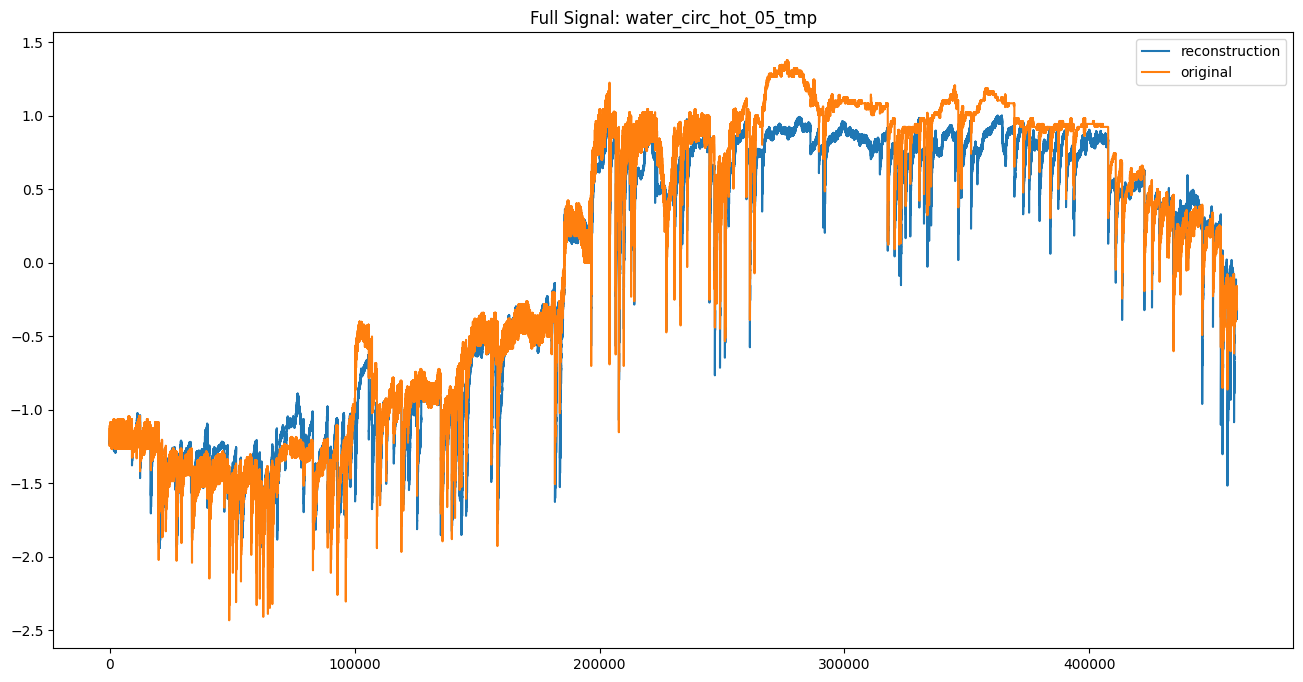

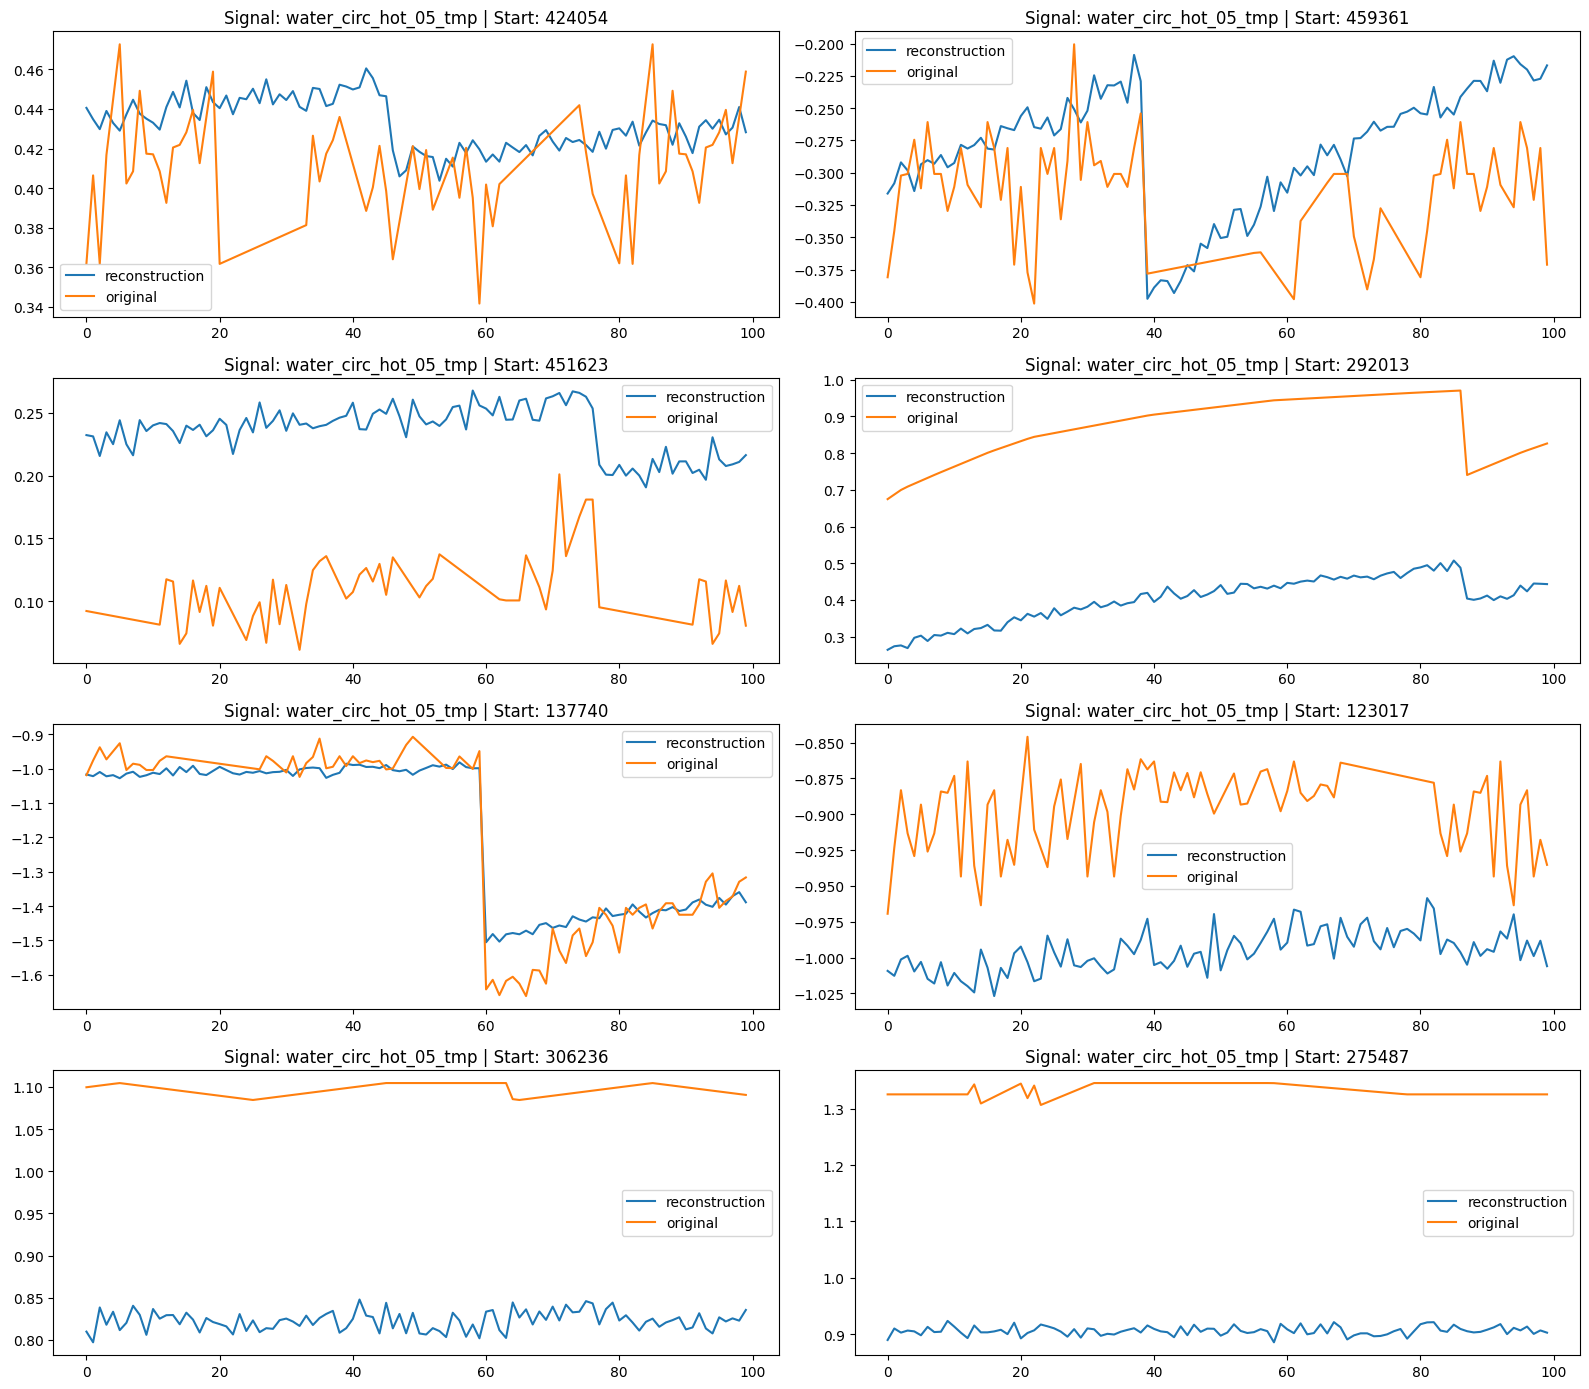

In [ ]:
signal_number = 77
plot_every = 1
viewing_window_size = window_size
rows, cols = 4, 2

# === First Big Plot ===
plt.figure(figsize=(16, 8))
plt.plot(
    reconstruction[:, signal_number][::plot_every], 
    label='reconstruction'
)
plt.plot(
    full_original[:, signal_number][::plot_every], 
    label='original'
)
plt.legend()
plt.title(f"Full Signal: {df.columns[signal_number]}")
plt.show()

# === Grid of Subplots ===
fig, axes = plt.subplots(rows, cols, figsize=(16, 14))

for i, ax in enumerate(axes.flatten()):
    # Generate Random Start
    start = int(np.random.uniform(0, full_original.shape[0] - viewing_window_size))

    # Plot Data
    ax.plot(
        reconstruction[start : start + viewing_window_size, signal_number][::plot_every], 
        label='reconstruction'
    )
    ax.plot(
        full_original[start : start + viewing_window_size, signal_number][::plot_every], 
        label='original'
    )
    
    ax.legend()
    ax.set_title(f"Signal: {df.columns[signal_number]} | Start: {start}")

plt.tight_layout()
plt.show()
